In [1]:
import os
import pickle
from scipy import signal
import libfmp.b
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from load_djembe_marker import *
from foot_module import onset_calculations, onset_extraction, onset_filtering, utils, onset_plot
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter, argrelmin, argrelmax
from pydub import AudioSegment
from scipy.signal import find_peaks
from pydub.generators import Triangle
import mir_eval
from compute_tempo import *
from mutils import DataHandler
from dance_evaluation import *

In [2]:
mvnfiles = ["BKO_E1_D1_01_Suku_T.mvnx", "BKO_E1_D1_02_Maraka_T.mvnx", "BKO_E1_D1_03_Wasulunka_T.mvnx", "BKO_E1_D2_04_Maraka_T.mvnx"]

filename = mvnfiles[3]
piece_name = os.path.basename(filename).split(".")[0]
data_handler = DataHandler()
motion_data, drum_onsets, start_f, end_f, start_t, end_t, cycle_onsets, beat_ref, bpm = data_handler.load_and_process_data(filename, mode = 'gr', drum = 'J2', section_idx=0)


Loaded BKO_E1_D2_04_Maraka_T.pkl


,Start,End,Length,Name,Notes,mocap,Start (in sec),End (in sec),Length (in sec),Number of mocap ind. turns,Number of mocap audiency instances,Number of mocap participation in gr
0,"00:00:31,080","00:01:09,500","00:00:38,420",gr,NaN,gr,31.08,69.5,38.42,1.0,3.0,1.0


Total Sections: 1
index 0 for first section
J2 tempo for the current section: 101.71 BPM


### Two Sensor (Velocity)

In [3]:
# SEGMENT_HEAD  SEGMENT_PELVIS   SEGMENT_T8  SEGMENT_LEFT_HAND  SEGMENT_LEFT_FOOT

sensorA_seg_name = 'SEGMENT_RIGHT_HAND'
sensorB_seg_name = 'SEGMENT_LEFT_HAND'

# sensorA_velocity = motion_data['velocity']["SEGMENT_PELVIS"]
sensorA_position = motion_data['position'][sensorA_seg_name]    # size (n, 3)    [start_f:end_f,:]
sensorB_position = motion_data['position'][sensorB_seg_name]    # size (n, 3)    [start_f:end_f,:]

sensorA_velocity = motion_data['velocity'][sensorA_seg_name]    # size (n, 3)    [start_f:end_f,:]
sensorB_velocity = motion_data['velocity'][sensorB_seg_name]    # size (n, 3)    [start_f:end_f,:]


# sensorA_velocity = calc_xy_yz_zx(sensorA_velocity)
# sensorB_velocity = calc_xy_yz_zx(sensorB_velocity)

# sensorA_velocity = calc_xyz(sensorA_velocity)
# sensorB_velocity = calc_xyz(sensorB_velocity)

# distance_vector= calculate_hand_distance_vectors(sensorA_velocity, sensorB_velocity)
# distance_vector = detrend_signal_array(distance_vector, cutoff= 0.8)

sensorA_position = detrend_signal_array(sensorA_position, cutoff= 0.5)
sensorB_position = detrend_signal_array(sensorB_position, cutoff= 0.5)


sensorA_velocity = detrend_signal_array(sensorA_velocity, cutoff= 0.5)
sensorB_velocity = detrend_signal_array(sensorB_velocity, cutoff= 0.5)

novelty_length = len(sensorA_velocity)
time_axis = np.arange(novelty_length)/240

mocap_fps = 240
window_size = 240*20 #corresponding to 10 sec
hop_size = 240*10
tempi_range = np.arange(30,121,1)

# tempo_json = main_one_sensor(distance_vector, mocap_fps, window_size, hop_size, tempi_range, distance_threshold=0.03, absolute='yes')    # 0.03
# sensor_dir_change_onsets = tempo_json["sensor_dir_change_onsets"]  
idx=0
tempo_json = main_two_sensor(sensorA_velocity[:,idx].reshape(-1,1), sensorB_velocity[:,idx].reshape(-1,1), 
                                        sensorA_position[:,idx].reshape(-1,1), sensorB_position[:,idx].reshape(-1,1), 
                                        mocap_fps, window_size, hop_size, tempi_range, distance_threshold=0.015,
                                        T_filter= 0.25)


sensorA_abs_vel = tempo_json["sensorA_abs_vel"]
sensorB_abs_vel = tempo_json["sensorB_abs_vel"]
sensorA_dir_change = tempo_json["sensorA_dir_change"]
sensorB_dir_change = tempo_json["sensorB_dir_change"]                         
sensorA_dir_change_f = tempo_json["sensorA_dir_change_f"]
sensorB_dir_change_f = tempo_json["sensorB_dir_change_f"]
                                                  
sensorAB_onsets = tempo_json["sensorAB_onsets"]

tempogram_ab = tempo_json["tempogram_ab"]
time_axis_seconds = tempo_json["time_axis_seconds"]
tempo_axis_bpm = tempo_json["tempo_axis_bpm"]

tempo_data_maxmethod = tempo_json["tempo_data_maxmethod"]
tempo_data_weightedkernel = tempo_json["tempo_data_weightedkernel"]
# tempo_data_combinedtempogram = tempo_json["tempo_data_combinedtempogram"]

# Max method
Aestimated_beat_pulse = tempo_data_maxmethod["estimated_beat_pulse"]
Atempo_curve = tempo_data_maxmethod["tempo_curve"]
Atempo_curve_time_axis = tempo_data_maxmethod["tempo_curve_time_axis"]
Aglobal_tempo_bpm = tempo_data_maxmethod["global_tempo_bpm"]

# Weighted method
Bestimated_beat_pulse = tempo_data_weightedkernel["estimated_beat_pulse"]
Btempo_curve = tempo_data_weightedkernel["tempo_curve"]
Btempo_curve_time_axis = tempo_data_weightedkernel["tempo_curve_time_axis"]
Bglobal_tempo_bpm = tempo_data_weightedkernel["global_tempo_bpm"]

# Combined method
# Cestimated_beat_pulse = tempo_data_combinedtempogram["estimated_beat_pulse"]
# Ctempo_curve = tempo_data_combinedtempogram["tempo_curve"]
# Ctempo_curve_time_axis = tempo_data_combinedtempogram["tempo_curve_time_axis"]
# Cglobal_tempo_bpm = tempo_data_combinedtempogram["global_tempo_bpm"]

# both_sensor_onsets_b = np.sum(sensor_dir_change_onsets, axis=1)
# both_sensor_onsets_b = np.where(both_sensor_onsets_b > 0, 1,0)
# both_sensor_onsets_bfil = filter_dir_onsets_by_threshold(both_sensor_onsets_b.reshape(-1,1), threshold_s=0.15)
# both_sensor_onsets = both_sensor_onsets_bfil.flatten()   # Binary onsets

dance_onset, estimated_beat_onset, drum_ref = data_handler.onsets_for_plotting(sensorAB_onsets, Aestimated_beat_pulse, novelty_length)
dance_bpm = data_handler.calc_tempo_from_onsets(dance_onset)

print("A:", np.average(Atempo_curve[start_f:end_f]))
print("B:", np.average(Btempo_curve[start_f:end_f]))
# print("C:", np.average(Ctempo_curve[start_f:end_f]))
print("bpm:", bpm)

Computing tempograms...
Tempograms generated
Tempograms generated
Computing max method...
Computing weighted method...
A: 102.83700249430647
B: 90.2266565448433
bpm: 101.71244684519017


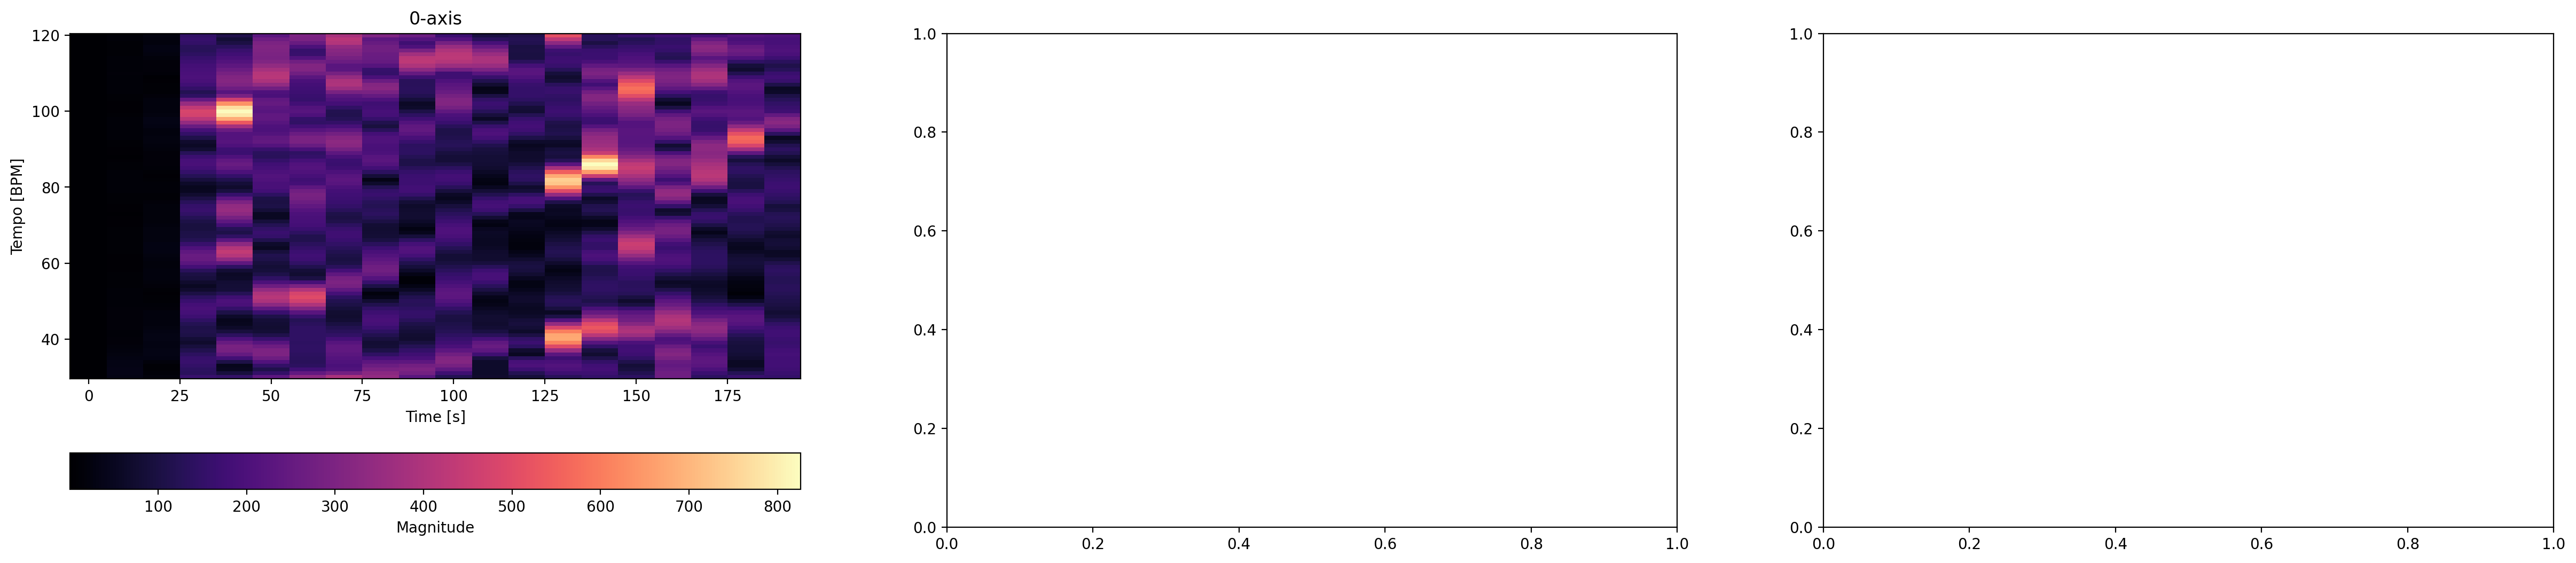

In [45]:
plot_tempogram_perAxis(tempo_json, islog= 'no', dpi=200)

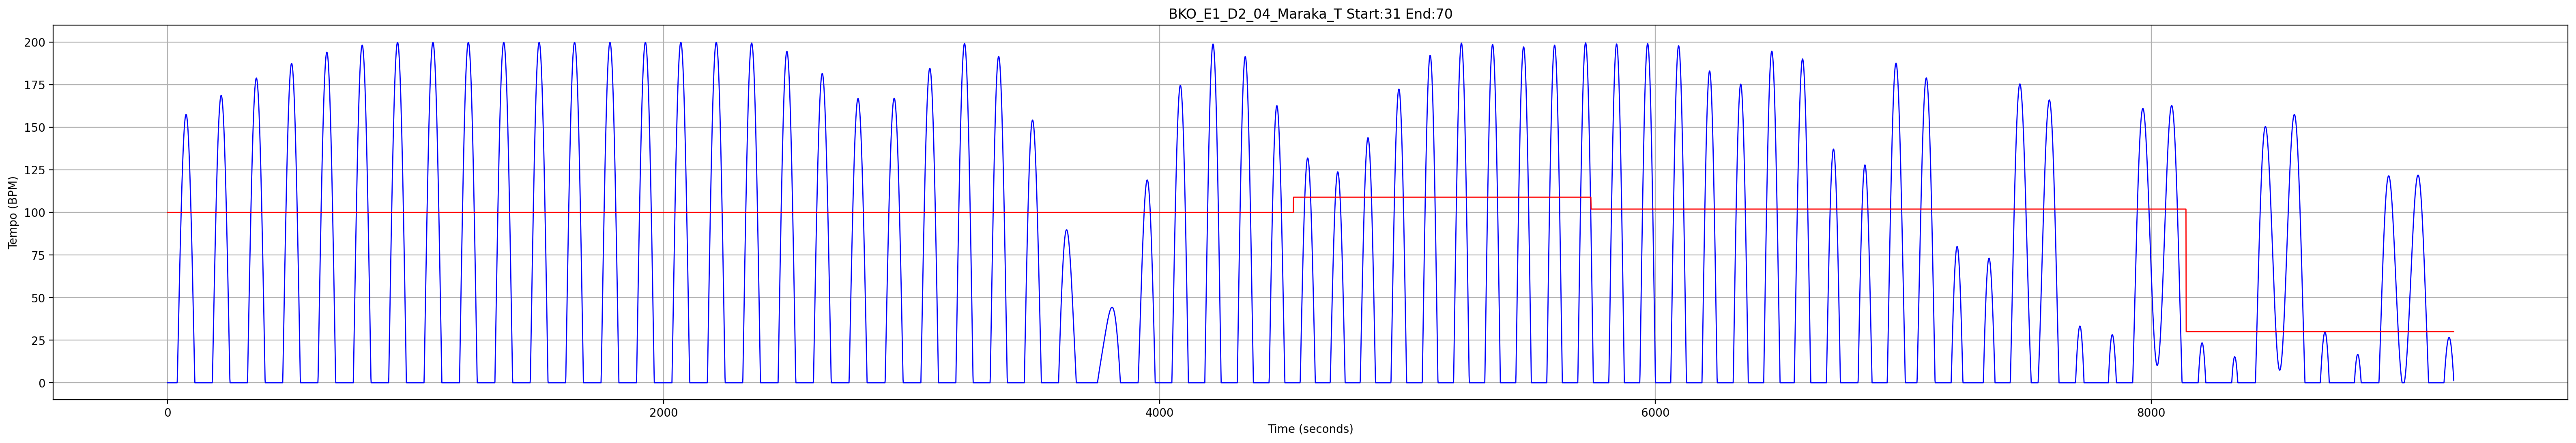

In [43]:
plt.figure(figsize=(40, 6), dpi=200)
plt.plot(100*Aestimated_beat_pulse[start_f:end_f], linewidth=1, color = 'b')
plt.plot(Atempo_curve[start_f:end_f], linewidth=1, color = 'r')

plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.title(f'{piece_name} Start:{round(start_t)} End:{round(end_t)}')
plt.grid(True)
plt.show()

In [ ]:
pos_b = np.where(sensorA_position[start_f:end_f,1]> 0, 1,0)

indices = np.where(sensorA_dir_change[start_f:end_f] > 0)[0]
filtered_indices = indices[pos_b[indices] == 1]

plt.figure(figsize=(40, 6), dpi=300)
# plt.plot(sensorA_position[start_f:end_f, 1], linewidth = 1.0, color='b')
plt.plot(pos_b, linewidth = 1.0, color='r')
plt.vlines(x= indices, ymin=0.0, ymax=1, color='g', linewidth=1.2,)

In [ ]:
# Per mode: drum onset and directional change onset plot

plt.figure(figsize=(40, 6), dpi=300)
window_size = 0.1
for onset in beat_ref:
    window_start = onset - (window_size/2)  # Start of the window (25ms before)
    window_end = onset + (window_size/2)   # End of the window (25ms after)
    
    # Plot shaded window
    plt.axvspan(window_start, window_end, color='red', alpha=0.2)
    # Plot reference onset as a vertical line
    plt.axvline(onset, color='red', linestyle='--', linewidth=0.8)

plt.vlines(x= dance_onset, ymin=0.0, ymax=1, color='g', linewidth=1.5,)
# plt.vlines(x= estimated_beat_onset, ymin=0.0, ymax=1, color='g', linewidth=1.5,)

plt.xlabel('Time (seconds)')
plt.title(f'{piece_name}')
plt.grid(True)
plt.show()

In [ ]:
results = evaluate_dance_onsets_with_half_beats(beat_ref, dance_onset, tolerance=0.15)
# results = evaluate_dance_onsets_with_half_beats(beat_ref, estimated_beat_onset, tolerance=0.15)

print("\nEvaluation Results:")
for key, value in results.items():
    print(f"{key}: {value}")
print("-"*40)

In [ ]:
# Evaluate using mir_eval
scores = mir_eval.beat.evaluate(drum_reference, beat_estimated)
precision, recall, f_measure = mir_eval.onset.f_measure(drum_reference, beat_estimated)
print(f'Precision: {precision}, Recall: {recall}, F-Measure: {f_measure}')

In [ ]:
#   Save audio plots

time = np.arange(novelty_length) / mocap_fps
peaks, _ = signal.find_peaks(Aestimated_beat_pulse)  # , prominence=0.02
beat_peaks_sec = time[peaks]


click_duration = 50  # milliseconds
click_freq = 1200  # Hz
file_name ="maraka_vel"
# Generate a single click sound
click = Triangle(click_freq).to_audio_segment(duration=click_duration)

onset_times = beat_peaks_sec  # kept_onsets/240   beat_peaks_sec
dN = novelty_length
total_duration = (dN/240)*1000  #  in milliseconds

audio = AudioSegment.silent(duration=total_duration)
for onset in onset_times:
    position = int(onset * 1000)  # Convert onset time to milliseconds
    audio = audio.overlay(click, position=position)

# Export the audio with clicks to a file
audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Both_Foot_new.wav"), format="wav")
# audio.export(os.path.join("/itf-fi-ml/home/sagardu/extract_feet_onset", f"{file_name}_Bothhand_dir.wav"), format="wav")